In [1]:
import sys
if not 'geopandas' in sys.modules:
  !pip install geopandas 
import geopandas as gpd 
import pandas as pd
import numpy as np
import math
from shapely.geometry import LineString

     |████████████████████████████████| 1.0MB 4.4MB/s 
     |████████████████████████████████| 14.8MB 305kB/s 
     |████████████████████████████████| 6.5MB 38.7MB/s 


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/geospatial statistical analysis/mcm2019C

/content/drive/MyDrive/Colab Notebooks/geospatial statistical analysis/mcm2019C


In [43]:
drugs = pd.read_csv("MCM_NFLIS_Data.csv")
cities = pd.read_csv("uscities.csv")
county = cities.groupby('county_fips').first().reset_index()

In [75]:
drugs.head(5)

,YYYY,State,COUNTY,FIPS_State,FIPS_County,FIPS_Combined,SubstanceName,DrugReports,TotalDrugReportsCounty,TotalDrugReportsState
0,2010,VA,ACCOMACK,51,1,51001,Propoxyphene,1,84,41462
1,2010,OH,ADAMS,39,1,39001,Morphine,9,527,70999
2,2010,PA,ADAMS,42,1,42001,Methadone,2,334,89981
3,2010,VA,ALEXANDRIA CITY,51,510,51510,Heroin,5,427,41462
4,2010,PA,ALLEGHENY,42,3,42003,Hydromorphone,5,8500,89981


In [76]:
drugs.shape

(24062, 10)

In [30]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * mis_val / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [77]:
missing_values_table(drugs) 

Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [86]:
# drugs.SubstanceName.value_counts() #total drug reports each substance
drugs.groupby('SubstanceName')['DrugReports'].sum().sort_values(ascending = False)

SubstanceName
Heroin                       310315
Oxycodone                    110173
Hydrocodone                   47370
Fentanyl                      47339
Buprenorphine                 34839
                              ...  
Metazocine                        1
Alphaprodine                      1
Dihydromorphone                   1
p-methoxybutyryl fentanyl         1
3-Fluorofentanyl                  1
Name: DrugReports, Length: 69, dtype: int64

In [36]:
drugs.State.value_counts() #total drug reports each state

OH    6354
VA    6218
KY    5429
PA    4362
WV    1699
Name: State, dtype: int64

In [38]:
drugs.groupby(['YYYY']).sum() #reports every year

,FIPS_State,FIPS_County,FIPS_Combined,DrugReports,TotalDrugReportsCounty,TotalDrugReportsState
YYYY,,,,,,
2010,113784,396144,114180144,61549,2542255,148090075
2011,106137,266432,106403432,60626,2400151,132401381
2012,109299,277699,109576699,65033,2384512,138827469
2013,115452,404801,115856801,74124,2528583,155825685
2014,112413,314762,112727762,79162,2620145,153507099
2015,111921,282923,112203923,84024,2737970,164412957
2016,132081,376805,132457805,90470,3778858,203307140
2017,152796,435481,153231481,95454,4872816,253120052


In [36]:
# merge drugs data with geospatial data (lat, lng)
drugs_county = drugs.merge(county[['county_fips', 'lat', 'lng']], how='left',left_on = 'FIPS_Combined', right_on = 'county_fips')

In [59]:
d_2017 = drugs_county[drugs_county.YYYY == 2017]
# drop null values
d_2017 = d_2017[d_2017['lat'].apply(lambda x: not math.isnan(x)) & (d_2017['lng'].apply(lambda x: not math.isnan(x)))].reset_index()

In [39]:
# Create the map
m_3 = folium.Map(location=[37.4316, -78.6569], tiles='cartodbpositron', zoom_start=8)

# Add points to the map
mc = MarkerCluster()
for idx, row in d_2017.iterrows():
    if not math.isnan(row['lat']) and not math.isnan(row['lng']):
        mc.add_child(Marker([row['lat'], row['lng']]))
m_3.add_child(mc)

# Display the map
m_3

In [68]:
d_2017_sum = d_2017.groupby('FIPS_Combined')['DrugReports'].sum().reset_index().merge(county[['county_fips', 'lat', 'lng']], how='left',left_on = 'FIPS_Combined', right_on = 'county_fips')
d_2017_sum

,FIPS_Combined,DrugReports,county_fips,lat,lng
0,21001,17,21001,37.1036,-85.3074
1,21003,20,21003,36.7521,-86.2018
2,21005,20,21005,38.0332,-84.9032
3,21007,1,21007,37.0750,-88.9748
4,21009,48,21009,37.0047,-85.9263
...,...,...,...,...,...
422,54099,26,54099,38.4026,-82.5822
423,54101,12,54101,38.4782,-80.4082
424,54103,3,54103,39.6636,-80.8569
425,54107,242,54107,39.2624,-81.5420


In [71]:
# Create a base map
m_4 = folium.Map(location=[37.4316, -78.6569], tiles='cartodbpositron', zoom_start=8)

def color_producer(val):
    if val < 5:
        return 'forestgreen'
    elif val <=20:
        return 'darkorange'
    else:
        return 'darkred'

def radius_producer(val): 
    if val <= 5:
        return 20
    elif val <= 10:
        return 80
    else:
        return 200
# Add a bubble map to the base map
for i in range(0,len(d_2017_sum)):
    Circle(
        location=[d_2017_sum.iloc[i]['lat'], d_2017_sum.iloc[i]['lng']],
        radius=radius_producer(int(d_2017_sum.iloc[i]['DrugReports'])),
        color=color_producer(d_2017_sum.iloc[i]['DrugReports'])).add_to(m_4)

# Display the map
m_4

Generating drugs spreading gif

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import openpyxl as xl
import pandas as pd

In [20]:
x = xl.load_workbook('solution/data/MCM_NFLIS_Data.xlsx')
data_sheet = x['Data']

rows = data_sheet.rows
columns = data_sheet.columns

lines = []
for column in columns:
    line = [col.value for col in column]
    lines.append(line)

year = np.array(lines[0][1:])
state_name = np.array(lines[1][1:])
county_name = np.array(lines[2][1:])
state = np.array(lines[3][1:]).astype(int)
county = np.array(lines[4][1:]).astype(int)
state_county = np.array(lines[5][1:]).astype(int)
drug_name = np.array(lines[6][1:])
drug_report = np.array(lines[7][1:]).astype(int)
drug_report_county = np.array(lines[8][1:]).astype(int)
drug_report_state = np.array(lines[9][1:]).astype(int)

In [21]:
state_county

array([51001, 39001, 42001, ..., 51197, 42133, 51199])

In [22]:
t = np.unique(state_county)

In [24]:
drug_tags = np.unique(drug_name)

In [25]:
county_loc = []
for x in t:
    loc = np.array(cities[(cities['county_fips'] == x)].loc[:, ['lat', 'lng']]).T
    county_loc.append([loc[1].mean(), loc[0].mean()])

county_loc = np.array(county_loc).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


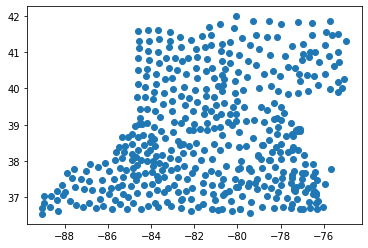

In [27]:
county_loc[0, 369]=-79.52351
county_loc[1, 369]=37.318585

plt.scatter(county_loc[0], county_loc[1])

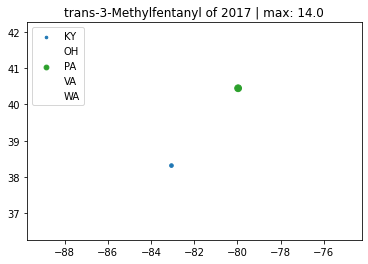

In [32]:
m = [21, 39, 42, 51, 54]
for drag in drug_tags:
    s = []
    for n in range(8):
        x = np.zeros(t.size)
        select = np.where((drug_name==drag)&(year==2010+n))
        for i in range(select[0].size):
            x[np.where((t == state_county[select][i]))] = drug_report[select][i]
        s.append(x)
    s = np.array(s)

    scaler = s.max() / 92
    
    for j in range(8):
        plt.clf()
        plt.title(r'{} of {} | max: {}'.format(drag, 2010+j, s.max()))
        
        for n in range(5):
            cut = np.where(((t/1000).astype(int) == m[n]))
            plt.scatter(county_loc[0][cut], county_loc[1][cut], s=np.array(s[j][cut])/scaler)
        plt.legend(['KY', 'OH', 'PA', 'VA', 'WA'])
    
        cut = np.where((s[j]==0))
        plt.scatter(county_loc[0][cut], county_loc[1][cut], s=np.array(s[j][cut])/scaler+0.5, c='w')
        plt.savefig(r'solution/temp/{}.png'.format(j))
    
    plt.clf()
    plt.title(r'{} of {} | max: {}'.format(drag, 2010+j, s.max()))
    
    for n in range(5):
        cut = np.where(((t/1000).astype(int) == m[n]))
        plt.scatter(county_loc[0][cut], county_loc[1][cut], s=np.array(s[j][cut])/scaler)
    plt.legend(['KY', 'OH', 'PA', 'VA', 'WA'])
    
    cut = np.where((s[j]==0))
    plt.scatter(county_loc[0][cut], county_loc[1][cut], s=np.array(s[j][cut])/scaler+0.5, c='w')
    plt.savefig(r'solution/temp/{}.png'.format(j+1))
    
    frames = []
    for i in range(9):
        frames.append(imageio.imread(r'solution/temp/{}.png'.format(i)))
    imageio.mimsave(r'solution/gifs/{} map.gif'.format(drag.replace('/', '^')), frames, 'GIF', duration = 0.5)